## This notebook illustrates how to analyze results from an A/B test

We assume that the metric we are analyzing is the click-through-rate (CTR).

Each event is either a click or not, therefore we can use Bernoulli distribution to model the events. 

Given data collected from a control group (A) and an exposed one (B), we would like to see if the data we gather allows us to draw a statistically significant conclusion. If it does, how much statistical power do we get.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as scs

from plot_functions import adjustAxeProperties

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
"""
  The method generates simulated data consisting of click events, given the 
  number of trials (N) and conversion rate (p) specified for the group A and B, 
  respectively.
"""  
def generte_data(N_A, N_B, p_A, p_B):
    
    N = N_A + N_B
    A_bernoulli = scs.bernoulli(p_A)
    B_bernoulli = scs.bernoulli(p_B)

    df_A = pd.DataFrame({})
    df_A['group'] = np.array(['A'] * N_A)
    df_A['converted'] = scs.bernoulli(p_A).rvs(size=N_A)
    
    df_B = pd.DataFrame({})
    df_B['group'] = np.array(['B'] * N_B)
    df_B['converted'] = scs.bernoulli(p_B).rvs(size=N_B)
    
    df = pd.concat([df_A, df_B], axis=0).reset_index(drop=True)
    return df
    

In [3]:
"""
  The method calculates the standard deviation of a Bernoulli-distributed variable,
  given its probability p.
"""
def calculate_standard_error(p, n):
    return np.sqrt(p * (1.0 - p)) / np.sqrt(n)

#### When generating the underlying data, we assume that the control group (A) has CTR=0.1, and the exposed group has CTR=0.112

In [4]:
np.random.seed(3890)
N_A = 1000
N_B = 500
p_A = 0.1
p_B = 0.112


In [5]:
ab_data = generte_data(N_A, N_B, p_A, p_B)

#### Aggregate the individual clicks and events to get empirical conversion rates

In [6]:
ab_summary = ab_data.pivot_table(index='group', values='converted', aggfunc=np.sum)
ab_summary['total'] = ab_data.pivot_table(index='group', values='converted', aggfunc=len)
ab_summary['rate'] = ab_data.pivot_table(index='group', values='converted', aggfunc=np.mean)


In [7]:
ab_summary

,converted,total,rate
group,,,
A,89,1000,0.089
B,54,500,0.108


#### The empirical result suggests that exposed group (B) has CTR = 0.108, which is 0.019 higher than the control group (A). The question is, is this result statistically significant?

In [8]:
empirical_p_A = ab_summary.loc['A']['rate']
empirical_p_B = ab_summary.loc['B']['rate']

standard_error_A = calculate_standard_error(empirical_p_A, N_A)
standard_error_B = calculate_standard_error(empirical_p_B, N_B)

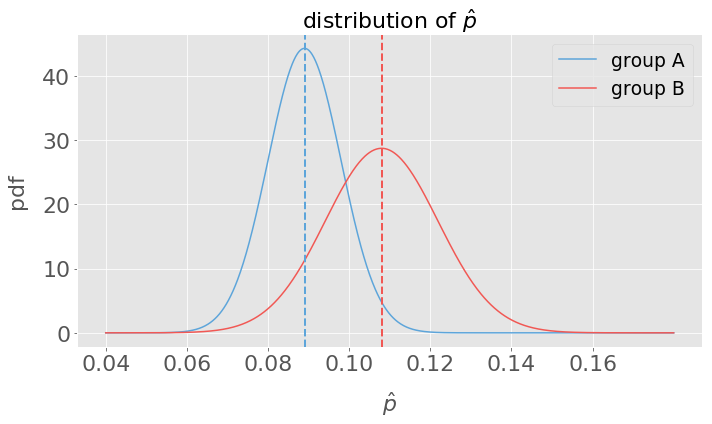

In [9]:
FONTSIZE = 22
plt.close('all')
fig, ax = plt.subplots(1, figsize=(10, 6))

x = np.linspace(0.04, 0.18, 1000)

pdf_A = scs.norm(empirical_p_A, standard_error_A).pdf(x)
pdf_B = scs.norm(empirical_p_B, standard_error_B).pdf(x)

ax.plot(x, pdf_A, label='group A', color='#5DA5DA')
ax.plot(x, pdf_B, label='group B', color='#F15854')

ax.axvline(empirical_p_A, linestyle='--', linewidth=2, color='#5DA5DA')
ax.axvline(empirical_p_B, linestyle='--', linewidth=2, color='#F15854')

ax.set_xticks(np.arange(0.04, 0.18, 0.02))
ax.set_xlabel(r'$\hat{p}$', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('pdf', fontsize=FONTSIZE, labelpad=15)

adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
ax.legend(loc='best', fontsize=FONTSIZE*0.85)
ax.set_title(r'distribution of $\hat{p}$', fontsize=FONTSIZE)

plt.tight_layout(w_pad=3.0, h_pad=1)

### Test statistical significance

In [10]:
significance_level = 0.05
null_hypothesis_critical_point = scs.norm(empirical_p_A, standard_error_A).ppf(1.0 - significance_level)

p_value = 1.0 - scs.norm(empirical_p_A, standard_error_A).cdf(empirical_p_B)

alternative_hypothesis_false_negative = scs.norm(empirical_p_B, standard_error_B).cdf(null_hypothesis_critical_point)
power = 1.0 - alternative_hypothesis_false_negative

null_hypothesis_critical_point, p_value, alternative_hypothesis_false_negative, power


(0.10381089996302054,
 0.01742563073539194,
 0.3814043333218427,
 0.6185956666781574)

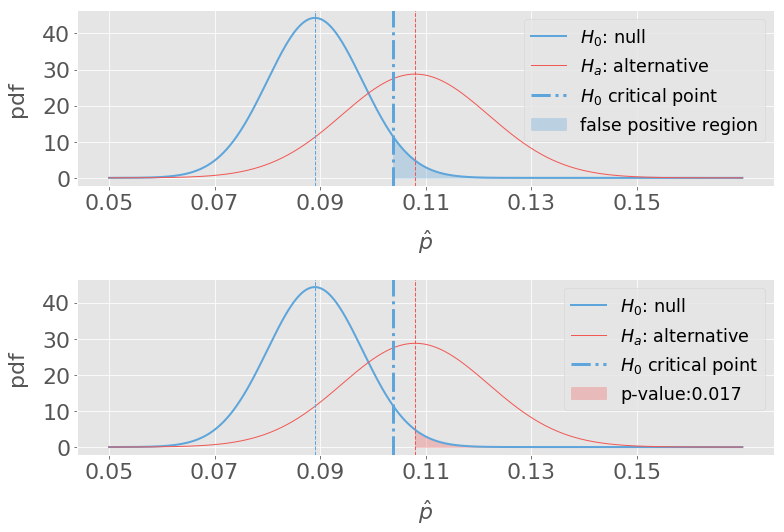

In [11]:
FONTSIZE = 30
plt.close('all')
fig = plt.figure(figsize=(11,7.5))
gs = matplotlib.gridspec.GridSpec(2, 1)

FONTSIZE = 22
XAXIS_LOWER_LIMIT = 0.05
XAXIS_UPPER_LIMIT = 0.17
x = np.linspace(0.05, XAXIS_UPPER_LIMIT, 1000)

pdf_A = scs.norm(empirical_p_A, standard_error_A).pdf(x)
pdf_B = scs.norm(empirical_p_B, standard_error_B).pdf(x)

COLOR_A = '#5DA5DA'
COLOR_B = '#F15854'

# First plot focuses on the null hypothesis
ax = plt.subplot(gs[0,0]) 
ax.plot(x, pdf_A, color=COLOR_A, linewidth=2, label=r'$H_0$: null')
ax.plot(x, pdf_B, color=COLOR_B, linewidth=1, label=r'$H_a$: alternative')

ax.axvline(empirical_p_A, linestyle='--', linewidth=1, color=COLOR_A)
ax.axvline(null_hypothesis_critical_point, linestyle='-.', linewidth=3, color=COLOR_A, label=r'$H_0$ critical point')
ax.axvline(empirical_p_B, linestyle='--', linewidth=1, color=COLOR_B)

shaded_x = np.linspace(start=null_hypothesis_critical_point, stop=XAXIS_UPPER_LIMIT, num=100)
shaded_y = scs.norm(empirical_p_A, standard_error_A).pdf(shaded_x)
ax.fill_between(shaded_x, shaded_y, color=COLOR_A, alpha=0.3, label='false positive region')

ax.set_xticks(np.arange(XAXIS_LOWER_LIMIT, XAXIS_UPPER_LIMIT, 0.02))
ax.set_xlabel(r'$\hat{p}$', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('pdf', fontsize=FONTSIZE, labelpad=15)

adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
ax.legend(loc='best', fontsize=FONTSIZE*0.8)


# Second plot focuses on p-value
ax = plt.subplot(gs[1,0]) 
ax.plot(x, pdf_A, color=COLOR_A, linewidth=2, label=r'$H_0$: null')
ax.plot(x, pdf_B, color=COLOR_B, linewidth=1, label=r'$H_a$: alternative')

ax.axvline(empirical_p_A, linestyle='--', linewidth=1, color=COLOR_A)
ax.axvline(null_hypothesis_critical_point, linestyle='-.', linewidth=3, color=COLOR_A, label=r'$H_0$ critical point')
ax.axvline(empirical_p_B, linestyle='--', linewidth=1, color=COLOR_B)

shaded_x = np.linspace(start=empirical_p_B, stop=XAXIS_UPPER_LIMIT, num=100)
shaded_y = scs.norm(empirical_p_A, standard_error_A).pdf(shaded_x)
ax.fill_between(shaded_x, shaded_y, color=COLOR_B, alpha=0.3, label=r'p-value:{0:.3f}'.format(p_value))

ax.set_xticks(np.arange(XAXIS_LOWER_LIMIT, XAXIS_UPPER_LIMIT, 0.02))
ax.set_xlabel(r'$\hat{p}$', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('pdf', fontsize=FONTSIZE, labelpad=15)

adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
ax.legend(loc='best', fontsize=FONTSIZE*0.8)


plt.tight_layout(w_pad=1.0, h_pad=2.0)


#### Based on the hypothesis test carried out above, the observation does fall in the critical region of the null hypothesis, with a p-value of 0.017, which is less than the significane level of 0.05 that we pre-determined. This means that we can reject the null hypothesis. 

The next question is, how much statistical power associated with the alternative hypothesis do we have?

### Plot false negative and power

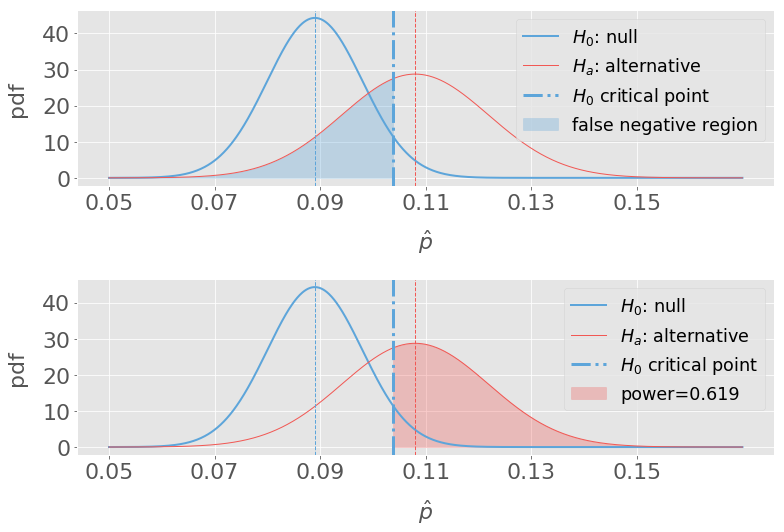

In [12]:
FONTSIZE = 30
plt.close('all')
fig = plt.figure(figsize=(11,7.5))
gs = matplotlib.gridspec.GridSpec(2, 1)

FONTSIZE = 22
XAXIS_LOWER_LIMIT = 0.05
XAXIS_UPPER_LIMIT = 0.17
x = np.linspace(0.05, XAXIS_UPPER_LIMIT, 1000)

pdf_A = scs.norm(empirical_p_A, standard_error_A).pdf(x)
pdf_B = scs.norm(empirical_p_B, standard_error_B).pdf(x)

COLOR_A = '#5DA5DA'
COLOR_B = '#F15854'

# First plot focuses on false negative
ax = plt.subplot(gs[0,0]) 
ax.plot(x, pdf_A, color=COLOR_A, linewidth=2, label=r'$H_0$: null')
ax.plot(x, pdf_B, color=COLOR_B, linewidth=1, label=r'$H_a$: alternative')

ax.axvline(empirical_p_A, linestyle='--', linewidth=1, color=COLOR_A)
ax.axvline(null_hypothesis_critical_point, linestyle='-.', linewidth=3, color=COLOR_A, label=r'$H_0$ critical point')
ax.axvline(empirical_p_B, linestyle='--', linewidth=1, color=COLOR_B)

shaded_x = np.linspace(start=XAXIS_LOWER_LIMIT, stop=null_hypothesis_critical_point, num=100)
shaded_y = scs.norm(empirical_p_B, standard_error_B).pdf(shaded_x)
ax.fill_between(shaded_x, shaded_y, color=COLOR_A, alpha=0.3, label='false negative region')

ax.set_xticks(np.arange(XAXIS_LOWER_LIMIT, XAXIS_UPPER_LIMIT, 0.02))
ax.set_xlabel(r'$\hat{p}$', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('pdf', fontsize=FONTSIZE, labelpad=15)

adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
ax.legend(loc='best', fontsize=FONTSIZE*0.8)


# Second plot focuses on power
ax = plt.subplot(gs[1,0]) 
ax.plot(x, pdf_A, color=COLOR_A, linewidth=2, label=r'$H_0$: null')
ax.plot(x, pdf_B, color=COLOR_B, linewidth=1, label=r'$H_a$: alternative')

ax.axvline(empirical_p_A, linestyle='--', linewidth=1, color=COLOR_A)
ax.axvline(null_hypothesis_critical_point, linestyle='-.', linewidth=3, color=COLOR_A, label=r'$H_0$ critical point')
ax.axvline(empirical_p_B, linestyle='--', linewidth=1, color=COLOR_B)

shaded_x = np.linspace(start=null_hypothesis_critical_point, stop=XAXIS_UPPER_LIMIT, num=100)
shaded_y = scs.norm(empirical_p_B, standard_error_B).pdf(shaded_x)
ax.fill_between(shaded_x, shaded_y, color=COLOR_B, alpha=0.3, label='power={0:.3f}'.format(power))

ax.set_xticks(np.arange(XAXIS_LOWER_LIMIT, XAXIS_UPPER_LIMIT, 0.02))
ax.set_xlabel(r'$\hat{p}$', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('pdf', fontsize=FONTSIZE, labelpad=15)

adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
ax.legend(loc='best', fontsize=FONTSIZE*0.8)


plt.tight_layout(w_pad=1.0, h_pad=2.0)


#### (Top plot) The distributions of the CTRs for group A (blue) and group B (red) have some overlap. Since we use a strict significance level for the null hypothesis, meaning that the critical region is on the far right tail of of $H_0$, inevitably, some results that are legitimately in group B will not be identified. These cases are represented by the blue shaded area under the $H_a$ curve. The area also corresponds to the false negative rate, $\beta$.


#### (Bottom plot) Same plot as the top one, but instead of false negative region, we plot its complementary, $1-\beta$, which is known as the statitical power (shaded red). The area that's under $H_a$ and above the critical line of $H_0$ corresponds to the statistical power.

### Determine the minimum sample size

#### In the above, we have already demonstrated how to calculate the statistical power. Assuming that we would like to have a statistical power of 0.8, how many samples do we need to declare a success of this A/B test? How many days should we need to run the test?

In [66]:
np.random.seed(3690)
daily_traffic = 100
control_fraction = 0.7
days = 50
all_data = []
for i in range(days):
    N_A = int(daily_traffic * control_fraction)
    N_B = daily_traffic - N_A
    data = generte_data(N_A, N_B, p_A, p_B)
    all_data.append(data)    

In [67]:
significance_level = 0.05

p_value_so_far = []
power_so_far = []
for i in range(len(all_data)):
    
    # aggregate the data up to the i-th day
    cumulative_data = pd.concat(all_data[0:i+1], axis=0).reset_index(drop=True)
    ab_summary = cumulative_data.pivot_table(index='group', values='converted', aggfunc=np.sum)
    ab_summary['total'] = cumulative_data.pivot_table(index='group', values='converted', aggfunc=len)
    ab_summary['rate'] = cumulative_data.pivot_table(index='group', values='converted', aggfunc=np.mean)
    
    # estimate the conversion rates and the associated uncertainties
    N_A = ab_summary.loc['A']['total']
    N_B = ab_summary.loc['B']['total']
        
    empirical_p_A = ab_summary.loc['A']['rate']
    empirical_p_B = ab_summary.loc['B']['rate']

    standard_error_A = calculate_standard_error(empirical_p_A, N_A)
    standard_error_B = calculate_standard_error(empirical_p_B, N_B)    
    
    # calculate p_value and power
    null_hypothesis_critical_point = scs.norm(empirical_p_A, standard_error_A).ppf(1.0 - significance_level)
    p_value = 1.0 - scs.norm(empirical_p_A, standard_error_A).cdf(empirical_p_B)
    alternative_hypothesis_false_negative = scs.norm(empirical_p_B, standard_error_B).cdf(null_hypothesis_critical_point)
    power = 1.0 - alternative_hypothesis_false_negative
        
    # save the results
    p_value_so_far.append(p_value)
    power_so_far.append(power)
        

In [68]:
results = pd.DataFrame({
    'days': np.arange(1, days+1),
    'p_value': p_value_so_far,
    'power': power_so_far
})

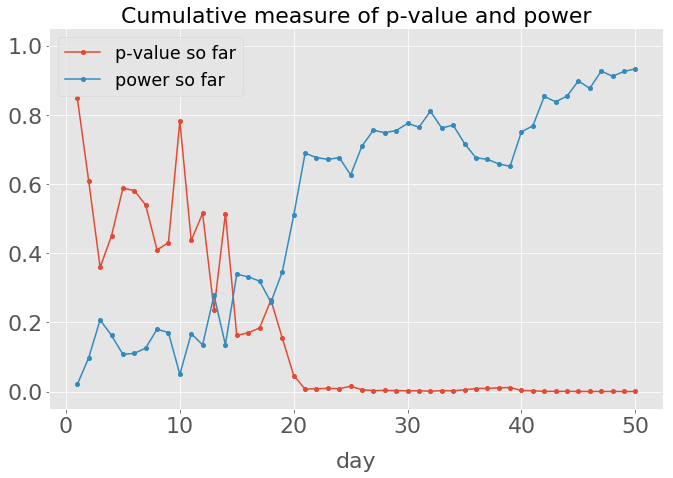

In [69]:
FONTSIZE = 22
plt.close('all')
fig, ax = plt.subplots(1, figsize=(11, 7))
ax.plot(results['days'], results['p_value'], marker='.', markersize=8, label='p-value so far')
ax.plot(results['days'], results['power'], marker='.', markersize=8, label='power so far')
ax.set_xlabel('day', labelpad=15, fontsize=FONTSIZE)
ax.set_ylim(-0.05, 1.05)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
ax.legend(loc='best', fontsize=FONTSIZE*0.8)
_ = ax.set_title('Cumulative measure of p-value and power', fontsize=FONTSIZE)

In [72]:
power_threshold = 0.8
results[results['power'] > power_threshold].head(1)['days'].iloc[0]

32

Therefore, we need to run the experiment for 32 days, or collecting 32 * 100 = 3200 samples in order to declare the A/B a success